# LAC Segregation

In [1]:
from act.cell_model import ACTCellModel
from act.simulator import ACTSimulator
from act.segregation import ACTSegregator
from act.act_types import SimulationParameters, CurrentInjection, PassiveProperties

import matplotlib.pyplot as plt
import numpy as np

/home/mwsrgf/act-venv/lib64/python3.9/site-packages/torch/__init__.py:955: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:432.)
  _C._set_default_tensor_type(t)
--No graphics will be displayed.


### LAC

Parameters (both original and segregated):
- Cm = 2.5
- gl = 3.5e-5 (S/cm2)
- el = -70 (mV)
- Capool: taucas = 1000, fcas_capool = 0.05

Modules:
- Spiking: [gbar_na3, gkdrbar_kdr],
- Bursting/Adapting: [gbar_nap, gmbar_im]

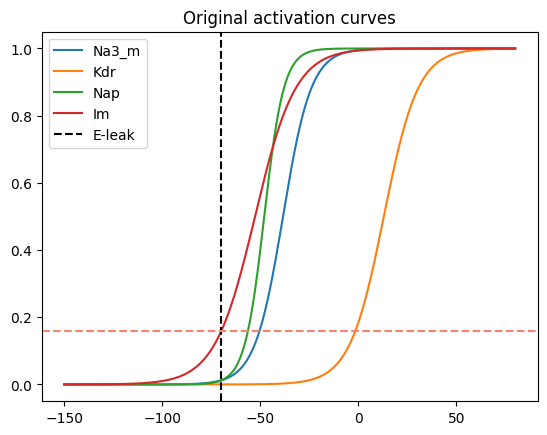

In [2]:
def Na3_m(v):
    return 1 / ( 1 + np.exp( ( - v - 38.43 ) / 7.2 ) )

def Na3_h(v):
    return 1 / ( 1 + np.exp( ( v + 50 ) / 4 ) )

def Kdr(v):
    return 1 / ( 1 + np.exp( ( - v + 13 ) / 8.738 ) )

def Nap(v):
    return 1 / ( 1 + np.exp( ( - v - 48 ) / 5 ) )

def Im(v):
    return 1 / ( 1 + np.exp( ( - v - 52.7 ) / 10.34 ) )

v = np.linspace(-150, 80, 1000)

plt.plot(v, Na3_m(v), label = 'Na3_m')
#plt.plot(v, Na3_h(v), label = 'Na3_h')
plt.plot(v, Kdr(v), label = 'Kdr')
plt.plot(v, Nap(v), label = 'Nap')
plt.plot(v, Im(v), label = 'Im')
plt.title("Original activation curves")
plt.axvline(-70, color = 'black', ls = '--', label = "E-leak")
plt.axhline(0.16, color = 'salmon', ls = '--')
plt.legend()

In [3]:
segregator = ACTSegregator()
segregated_bursting = segregator.segregate(v, [Nap(v), Im(v)])

Update the modfiles with the following:
----------
Activation curve 0:

        :Segregation
        if (v < -67.88) {
        replace_with_var_name = 0.009 * v + 0.624
        }
        if (v < -69.88) {
        replace_with_var_name = 0
        }
        
----------
Activation curve 1:

        :Segregation
        if (v < -67.88) {
        replace_with_var_name = 0.092 * v + 6.461
        }
        if (v < -69.88) {
        replace_with_var_name = 0
        }
        


In [4]:
segregated_spiking = segregator.segregate(v, [Na3_m(v), Kdr(v)])

Update the modfiles with the following:
----------
Activation curve 0:

        :Segregation
        if (v < -48.541) {
        replace_with_var_name = 0.097 * v + 4.895
        }
        if (v < -50.541) {
        replace_with_var_name = 0
        }
        
----------
Activation curve 1:

        :Segregation
        if (v < -48.541) {
        replace_with_var_name = 0.0 * v + 0.022
        }
        if (v < -50.541) {
        replace_with_var_name = 0
        }
        


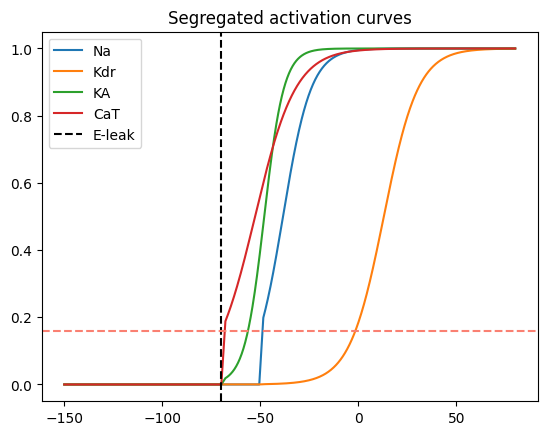

In [5]:
for ac, ac_name in zip(segregated_spiking, ["Na", "Kdr"]):
    plt.plot(v, ac, label = ac_name)
for ac, ac_name in zip(segregated_bursting, ["KA", "CaT", "CaS"]):
    plt.plot(v, ac, label = ac_name)

plt.title("Segregated activation curves")
plt.axvline(-70, color = 'black', ls = '--', label = "E-leak")
plt.axhline(0.16, color = 'salmon', ls = '--')
plt.legend()

In [6]:
orig_cell = ACTCellModel(
    path_to_hoc_file = "./orig/template.hoc",
    path_to_mod_files = "./orig/modfiles",
    active_channels = ["gbar_na3", "gkdrbar_kdr", "gbar_nap", "gmbar_im"],
    passive_properties = PassiveProperties(leak_conductance_variable = "glbar_leak"),
    cell_name = "LAC_orig"
)

simulator = ACTSimulator(output_folder_name = "output")
simulator.submit_job(orig_cell, SimulationParameters(sim_name = "LAC_orig", sim_idx = 1, h_celsius = 31.0 , h_v_init=-70, CI = CurrentInjection(type = "constant", amp = 0.3)))
simulator.run_jobs(1)


        ACTSimulator (2024)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


In [7]:
seg_cell = ACTCellModel(
    path_to_hoc_file = "./seg/template.hoc",
    path_to_mod_files = "./seg/modfiles",
    active_channels = ["gbar_na3", "gkdrbar_kdr", "gbar_nap", "gmbar_im"],
    passive_properties = PassiveProperties(leak_conductance_variable = "glbar_leak"),
    cell_name = "LAC_seg"
)

simulator = ACTSimulator(output_folder_name = "output")
simulator.submit_job(seg_cell, SimulationParameters(sim_name = "LAC_seg", sim_idx = 1, h_celsius = 31.0 , h_v_init=-70 , CI = CurrentInjection(type = "constant", amp = 0.3)))
simulator.run_jobs(1)


        ACTSimulator (2024)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


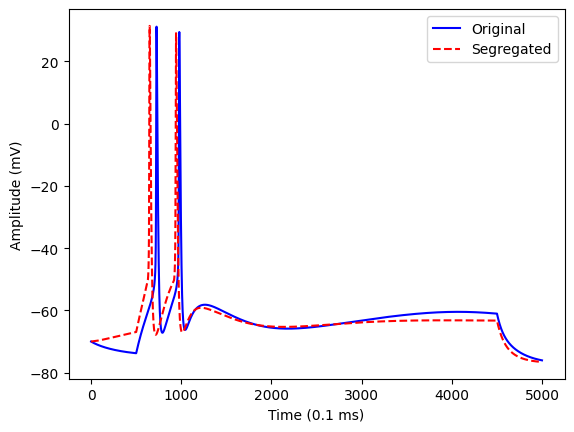

In [8]:
orig_out = np.load("output/LAC_orig/out_1.npy")
seg_out = np.load("output/LAC_seg/out_1.npy")

plt.plot(orig_out[:, 0], label = "Original", c = 'blue')
plt.plot(seg_out[:, 0], label = "Segregated", ls = '--', c = 'red')
plt.ylabel("Amplitude (mV)")
plt.xlabel("Time (0.1 ms)")
plt.legend()